# 实时负载预测与资源管理 - 数据预处理

本笔记本专注于从用户视角进行负载预测的第一步：数据预处理。我们将使用Google集群数据集中的cluster_1数据。

In [68]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# 设置可视化样式
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 1. 数据加载与探索

In [69]:
# 读取cluster_1数据
data_path = 'data/cluster_1.csv'
try:
    # 先读取少量数据以了解数据结构
    df_sample = pd.read_csv(data_path, nrows=1000)
    print(f"成功读取样本数据，形状: {df_sample.shape}")
    
    # 查看数据类型和基本信息
    display(df_sample.info())
    
    # 显示前几行数据
    display(df_sample.head())
    
    # 查看列名
    print("列名列表:")
    print(df_sample.columns.tolist())
    
except Exception as e:
    print(f"读取数据时出错: {e}")

成功读取样本数据，形状: (1000, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1000 non-null   int64  
 1   time                             1000 non-null   int64  
 2   instance_events_type             1000 non-null   int64  
 3   collection_id                    1000 non-null   int64  
 4   scheduling_class                 1000 non-null   int64  
 5   collection_type                  1000 non-null   int64  
 6   priority                         1000 non-null   int64  
 7   alloc_collection_id              1000 non-null   int64  
 8   instance_index                   1000 non-null   int64  
 9   machine_id                       1000 non-null   int64  
 10  resource_request                 1000 non-null   object 
 11  constraint                       1000 non-null   object 
 1

None

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request,constraint,collections_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler,start_time,end_time,average_usage,maximum_usage,random_sample_usage,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,12,204389347359,3,39516992187,2,0,0,0,3658,374219354303,"{'cpus': 0.0025177001953125, 'memory': 0.00022...",[],3,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,WS2kraTQdfsFtOIepw9SIo7ETi2ag8uwy7gt2MrpIe0=,VJ0ExwthLLpbqbyOA77EoNypzEiPYg3mECxUve0GCnY=,[],3.0,0.0,85136000000,85138000000,"{'cpus': 0.0, 'memory': 8.58306884765625e-06}","{'cpus': 0.0, 'memory': 8.58306884765625e-06}","{'cpus': 0.0, 'memory': None}",0.000232,0.000000,1.417979,0.003366,1.000000,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0.],1,FINISH,0
1,15,1129358774407,5,330587204926,2,0,360,330587135936,882,104790909291,"{'cpus': 0.02288818359375, 'memory': 0.0013027...",[],5,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,sKvpQodvOVYLFyh/UzTcFk1/JfjwK22JNnim9cKg1Rs=,mOIaNf8mXWKMT1ODsgfz3yhpFBedgNmcMaskvu55SBc=,[],2.0,0.0,1475400000000,1475700000000,"{'cpus': 0.031982421875, 'memory': 0.019226074...","{'cpus': 0.0692138671875, 'memory': 0.02062988...","{'cpus': 0.03131103515625, 'memory': None}",0.000000,0.002110,0.830359,0.001282,1.000000,[0.00041485 0.02163696 0.02450562 0.02798462 0...,[0.04284668 0.04309082 0.043396 0.04370117 0...,1,LOST,0
2,20,2220916046503,2,39516997747,2,0,0,0,2249,20738137,"{'cpus': 0.001861572265625, 'memory': 0.000199...",[],2,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,AbfLM/72wWE5g5N3WQHZ1wC0R8mV5trtLcKtgLVs88I=,ie5iGahM0adHFVwiIPBS9clQiQ0SrDQhN8bgC3FIUuI=,[],3.0,0.0,1627457000000,1627484000000,"{'cpus': 0.00030994415283203125, 'memory': 0.0...","{'cpus': 0.00144195556640625, 'memory': 0.0001...","{'cpus': 0.00031185150146484375, 'memory': None}",0.000258,0.000009,NaN,NaN,0.962963,[0.00019264 0.00024414 0.00026989 0.00027847 0...,[0.0004158 0.00041962 0.00042343 0.00042725 0...,1,FAIL,1
3,37,841608467990,5,382097962345,0,0,200,0,880,376665049364,"{'cpus': 0.0014972686767578125, 'memory': 0.00...",[],5,65cQTKg4RY0cw6wNHATarIqU6l5Yc2+sbFK5arfjCwk=,zpD9J3ZzovUudiyCQBvSpUJkdZlRof221D+fPljiVvM=,H5bzplCwVO8I4dsd2UoojkGpeVeWe1EnI4f1st/nXdY=,[],3.0,0.0,842400000000,842700000000,"{'cpus': 0.00017452239990234375, 'memory': 0.0...","{'cpus': 0.0007162094116210938, 'memory': 0.00...","{'cpus': 0.0001697540283203125, 'memory': None}",0.003777,0.000041,4.696661,0.017397,1.000000,[0.00011253 0.00013733 0.00014305 0.00014973 0...,[0.00022125 0.00023079 0.00024128 0.00025082 0...,1,LOST,0
4,41,409734022376,3,379491243491,1,0,103,0,3235,102983741786,"{'cpus': 0.002288818359375, 'memory': 0.004364...",[],3,VhRskANtB0POa8bH7ANXbm44CNdwIsEjtfv+O8OwFEM=,DV0rAim0qIinUuhrqLjdDqDdTQ4dljfb+si3fNTB3Hk=,7v7xx6nhItWe39IUci6O9NkAId6A7l/qPBmLmjCPiRQ=,[],2.0,1.0,454200000000,454500000000,"{'cpus': 0.000667572021484375, 'memory': 0.002...","{'cpus': 0.0067901611328125, 'memory': 0.00230...","{'cpus': 0.002025604248046875, 'memory': None}",0.004364,0.000294,3.111059,0.018562,1.000000,[0.00027561 0.00037098 0.00040054 0.00042343 0...,[0.00107002 0.00112152 0.00136375 0.00145149 0...,1,FINISH,0


列名列表:
['Unnamed: 0', 'time', 'instance_events_type', 'collection_id', 'scheduling_class', 'collection_type', 'priority', 'alloc_collection_id', 'instance_index', 'machine_id', 'resource_request', 'constraint', 'collections_events_type', 'user', 'collection_name', 'collection_logical_name', 'start_after_collection_ids', 'vertical_scaling', 'scheduler', 'start_time', 'end_time', 'average_usage', 'maximum_usage', 'random_sample_usage', 'assigned_memory', 'page_cache_memory', 'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate', 'cpu_usage_distribution', 'tail_cpu_usage_distribution', 'cluster', 'event', 'failed']


## 2. 数据预处理

基于探索结果，我们将执行以下预处理步骤：
1. 转换时间格式
2. 选择与用户视角相关的特征
3. 处理缺失值
4. 数据规范化/标准化
5. 构建时间序列特征

In [70]:
# 读取完整数据（如果数据量太大，考虑使用chunk方式读取）
try:
    print("开始读取完整数据集...")
    # 读取前100万行数据用于初步分析（避免内存问题）
    # 实际应用中可能需要调整或使用流式处理
    df = pd.read_csv(data_path, nrows=1000000)
    print(f"成功读取数据，形状: {df.shape}")
except Exception as e:
    print(f"读取完整数据时出错: {e}")

开始读取完整数据集...
成功读取数据，形状: (42713, 34)


### 2.1 时间特征处理

In [71]:
# 处理时间特征
try:
    # 检查是否存在时间相关列
    time_columns = [col for col in df.columns if 'time' in col.lower()]
    print(f"时间相关列: {time_columns}")
    
    # 转换时间列格式
    # 注意：需要根据实际数据格式调整转换方法
    for col in time_columns:
        if col in df.columns:
            # 假设时间戳是微秒级别
            if df[col].dtype == 'int64' or df[col].dtype == 'float64':
                # 如果是unix时间戳格式
                df[f'{col}_dt'] = pd.to_datetime(df[col], unit='us')
                print(f"转换列 {col} 为日期时间格式")
            else:
                # 尝试常规日期时间转换
                try:
                    df[f'{col}_dt'] = pd.to_datetime(df[col])
                    print(f"转换列 {col} 为日期时间格式")
                except:
                    print(f"无法转换列 {col} 为日期时间格式")
    
    # 显示转换后的时间列
    time_dt_columns = [col for col in df.columns if '_dt' in col]
    if time_dt_columns:
        display(df[time_dt_columns].head())
except Exception as e:
    print(f"处理时间特征时出错: {e}")

时间相关列: ['time', 'start_time', 'end_time']
转换列 time 为日期时间格式
转换列 start_time 为日期时间格式
转换列 end_time 为日期时间格式


,time_dt,start_time_dt,end_time_dt
0,1970-01-03 08:46:29.347359,1970-01-01 23:38:56,1970-01-01 23:38:58
1,1970-01-14 01:42:38.774407,1970-01-18 01:50:00,1970-01-18 01:55:00
2,1970-01-26 16:55:16.046503,1970-01-19 20:04:17,1970-01-19 20:04:44
3,1970-01-10 17:46:48.467990,1970-01-10 18:00:00,1970-01-10 18:05:00
4,1970-01-05 17:48:54.022376,1970-01-06 06:10:00,1970-01-06 06:15:00


### 2.2 选择用户视角相关特征

In [72]:
# 从用户视角选择相关特征
user_features = [
    # 用户标识
    'user', 'collection_id', 'collection_name', 'collection_logical_name',
    
    # 时间信息
    'time', 'time_dt', 'start_time', 'start_time_dt', 'end_time', 'end_time_dt',
    
    # 资源请求和使用
    'resource_request', 'average_usage', 'maximum_usage',
    'cpu_usage_distribution', 'tail_cpu_usage_distribution',
    
    # 其他重要特征
    'priority', 'instance_index', 'event', 'failed'
]

# 过滤实际存在的列
user_features = [col for col in user_features if col in df.columns]
print(f"选择的用户视角特征: {user_features}")

# 创建用户视角的数据子集
df_user = df[user_features].copy()
print(f"用户视角数据集形状: {df_user.shape}")
display(df_user.head())

选择的用户视角特征: ['user', 'collection_id', 'collection_name', 'collection_logical_name', 'time', 'time_dt', 'start_time', 'start_time_dt', 'end_time', 'end_time_dt', 'resource_request', 'average_usage', 'maximum_usage', 'cpu_usage_distribution', 'tail_cpu_usage_distribution', 'priority', 'instance_index', 'event', 'failed']
用户视角数据集形状: (42713, 19)


,user,collection_id,collection_name,collection_logical_name,time,time_dt,start_time,start_time_dt,end_time,end_time_dt,resource_request,average_usage,maximum_usage,cpu_usage_distribution,tail_cpu_usage_distribution,priority,instance_index,event,failed
0,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,39516992187,WS2kraTQdfsFtOIepw9SIo7ETi2ag8uwy7gt2MrpIe0=,VJ0ExwthLLpbqbyOA77EoNypzEiPYg3mECxUve0GCnY=,204389347359,1970-01-03 08:46:29.347359,85136000000,1970-01-01 23:38:56,85138000000,1970-01-01 23:38:58,"{'cpus': 0.0025177001953125, 'memory': 0.00022...","{'cpus': 0.0, 'memory': 8.58306884765625e-06}","{'cpus': 0.0, 'memory': 8.58306884765625e-06}",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0.],0,3658,FINISH,0
1,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,330587204926,sKvpQodvOVYLFyh/UzTcFk1/JfjwK22JNnim9cKg1Rs=,mOIaNf8mXWKMT1ODsgfz3yhpFBedgNmcMaskvu55SBc=,1129358774407,1970-01-14 01:42:38.774407,1475400000000,1970-01-18 01:50:00,1475700000000,1970-01-18 01:55:00,"{'cpus': 0.02288818359375, 'memory': 0.0013027...","{'cpus': 0.031982421875, 'memory': 0.019226074...","{'cpus': 0.0692138671875, 'memory': 0.02062988...",[0.00041485 0.02163696 0.02450562 0.02798462 0...,[0.04284668 0.04309082 0.043396 0.04370117 0...,360,882,LOST,0
2,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,39516997747,AbfLM/72wWE5g5N3WQHZ1wC0R8mV5trtLcKtgLVs88I=,ie5iGahM0adHFVwiIPBS9clQiQ0SrDQhN8bgC3FIUuI=,2220916046503,1970-01-26 16:55:16.046503,1627457000000,1970-01-19 20:04:17,1627484000000,1970-01-19 20:04:44,"{'cpus': 0.001861572265625, 'memory': 0.000199...","{'cpus': 0.00030994415283203125, 'memory': 0.0...","{'cpus': 0.00144195556640625, 'memory': 0.0001...",[0.00019264 0.00024414 0.00026989 0.00027847 0...,[0.0004158 0.00041962 0.00042343 0.00042725 0...,0,2249,FAIL,1
3,65cQTKg4RY0cw6wNHATarIqU6l5Yc2+sbFK5arfjCwk=,382097962345,zpD9J3ZzovUudiyCQBvSpUJkdZlRof221D+fPljiVvM=,H5bzplCwVO8I4dsd2UoojkGpeVeWe1EnI4f1st/nXdY=,841608467990,1970-01-10 17:46:48.467990,842400000000,1970-01-10 18:00:00,842700000000,1970-01-10 18:05:00,"{'cpus': 0.0014972686767578125, 'memory': 0.00...","{'cpus': 0.00017452239990234375, 'memory': 0.0...","{'cpus': 0.0007162094116210938, 'memory': 0.00...",[0.00011253 0.00013733 0.00014305 0.00014973 0...,[0.00022125 0.00023079 0.00024128 0.00025082 0...,200,880,LOST,0
4,VhRskANtB0POa8bH7ANXbm44CNdwIsEjtfv+O8OwFEM=,379491243491,DV0rAim0qIinUuhrqLjdDqDdTQ4dljfb+si3fNTB3Hk=,7v7xx6nhItWe39IUci6O9NkAId6A7l/qPBmLmjCPiRQ=,409734022376,1970-01-05 17:48:54.022376,454200000000,1970-01-06 06:10:00,454500000000,1970-01-06 06:15:00,"{'cpus': 0.002288818359375, 'memory': 0.004364...","{'cpus': 0.000667572021484375, 'memory': 0.002...","{'cpus': 0.0067901611328125, 'memory': 0.00230...",[0.00027561 0.00037098 0.00040054 0.00042343 0...,[0.00107002 0.00112152 0.00136375 0.00145149 0...,103,3235,FINISH,0


### 2.3 提取和处理资源使用信息

In [73]:
# 处理可能的非标准JSON格式
def extract_resource(x):
    if not isinstance(x, str):
        return np.nan, np.nan
    
    # 处理字典字符串格式
    try:
        # 尝试直接解析
        data = json.loads(x)
        return data.get('cpus', np.nan), data.get('memory', np.nan)
    except:
        # 如果不是标准JSON，尝试使用eval安全解析字典形式
        try:
            import ast
            data = ast.literal_eval(x)
            return data.get('cpus', np.nan), data.get('memory', np.nan)
        except:
            return np.nan, np.nan

# 处理资源请求和使用信息
try:
    # 检查资源列的格式
    resource_cols = ['resource_request', 'average_usage', 'maximum_usage']
    resource_cols = [col for col in resource_cols if col in df_user.columns]
    
    if resource_cols:
        display(df_user[resource_cols].head())
        
        # 假设资源列是JSON格式或具有特定结构的字符串
        for col in resource_cols:
            # 尝试提取CPU和内存信息
            try:
                # 示例：如果是JSON字符串形式
                if df_user[col].dtype == 'object':
                    # 尝试解析JSON
                    try:
                        import json
                        # 提取CPU和内存
                        # 应用提取函数
                        df_user[[f'{col}_cpu', f'{col}_memory']] = df_user[col].apply(extract_resource).apply(pd.Series)
                        print(f"从{col}中提取CPU和内存信息")
                    except:
                        print(f"无法从{col}中提取资源信息，可能需要检查数据格式")
            except Exception as e:
                print(f"处理{col}时出错: {e}")
    
    # 显示提取的资源信息
    extracted_cols = [col for col in df_user.columns if '_cpu' in col or '_memory' in col]
    if extracted_cols:
        display(df_user[extracted_cols].head())
except Exception as e:
    print(f"处理资源信息时出错: {e}")

,resource_request,average_usage,maximum_usage
0,"{'cpus': 0.0025177001953125, 'memory': 0.00022...","{'cpus': 0.0, 'memory': 8.58306884765625e-06}","{'cpus': 0.0, 'memory': 8.58306884765625e-06}"
1,"{'cpus': 0.02288818359375, 'memory': 0.0013027...","{'cpus': 0.031982421875, 'memory': 0.019226074...","{'cpus': 0.0692138671875, 'memory': 0.02062988..."
2,"{'cpus': 0.001861572265625, 'memory': 0.000199...","{'cpus': 0.00030994415283203125, 'memory': 0.0...","{'cpus': 0.00144195556640625, 'memory': 0.0001..."
3,"{'cpus': 0.0014972686767578125, 'memory': 0.00...","{'cpus': 0.00017452239990234375, 'memory': 0.0...","{'cpus': 0.0007162094116210938, 'memory': 0.00..."
4,"{'cpus': 0.002288818359375, 'memory': 0.004364...","{'cpus': 0.000667572021484375, 'memory': 0.002...","{'cpus': 0.0067901611328125, 'memory': 0.00230..."


从resource_request中提取CPU和内存信息
从average_usage中提取CPU和内存信息
从maximum_usage中提取CPU和内存信息


,tail_cpu_usage_distribution,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
0,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.002518,0.000221,0.000000,0.000009,0.000000,0.000009
1,[0.04284668 0.04309082 0.043396 0.04370117 0...,0.022888,0.001303,0.031982,0.019226,0.069214,0.020630
2,[0.0004158 0.00041962 0.00042343 0.00042725 0...,0.001862,0.000199,0.000310,0.000131,0.001442,0.000137
3,[0.00022125 0.00023079 0.00024128 0.00025082 0...,0.001497,0.000855,0.000175,0.001303,0.000716,0.001305
4,[0.00107002 0.00112152 0.00136375 0.00145149 0...,0.002289,0.004364,0.000668,0.002258,0.006790,0.002300


### 2.4 处理缺失值

In [74]:
# 检查缺失值
missing_values = df_user.isnull().sum()
missing_percentage = (missing_values / len(df_user)) * 100

missing_df = pd.DataFrame({
    '缺失值数量': missing_values,
    '缺失百分比': missing_percentage
}).sort_values('缺失百分比', ascending=False)

display(missing_df[missing_df['缺失值数量'] > 0])

# 处理缺失值
# 方法1：移除缺失值过多的列
threshold = 50  # 50%缺失率阈值
columns_to_drop = missing_df[missing_df['缺失百分比'] > threshold].index.tolist()
if columns_to_drop:
    print(f"移除缺失值过多的列: {columns_to_drop}")
    df_user = df_user.drop(columns=columns_to_drop)

# 方法2：用特定值填充缺失值
# 数值型列用0或均值填充
numeric_cols = df_user.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if df_user[col].isnull().sum() > 0:
        # 使用0填充
        df_user[col] = df_user[col].fillna(0)
        print(f"用0填充{col}的缺失值")

# 分类列用最频繁值填充
categorical_cols = df_user.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_user[col].isnull().sum() > 0:
        # 使用最频繁值填充
        most_frequent = df_user[col].mode()[0]
        df_user[col] = df_user[col].fillna(most_frequent)
        print(f"用最频繁值'{most_frequent}'填充{col}的缺失值")

# 检查处理后的缺失值
missing_after = df_user.isnull().sum()
if missing_after.sum() > 0:
    print("处理后仍有缺失值的列:")
    display(missing_after[missing_after > 0])
else:
    print("所有缺失值已处理")

,缺失值数量,缺失百分比
resource_request_memory,1,0.002341
resource_request_cpu,1,0.002341
resource_request,1,0.002341


用0填充resource_request_cpu的缺失值
用0填充resource_request_memory的缺失值
用最频繁值'{'cpus': 0.011474609375, 'memory': 0.0013027191162109375}'填充resource_request的缺失值
所有缺失值已处理


In [75]:
df_user

,user,collection_id,collection_name,collection_logical_name,time,time_dt,start_time,start_time_dt,end_time,end_time_dt,resource_request,average_usage,maximum_usage,cpu_usage_distribution,tail_cpu_usage_distribution,priority,instance_index,event,failed,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
0,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,39516992187,WS2kraTQdfsFtOIepw9SIo7ETi2ag8uwy7gt2MrpIe0=,VJ0ExwthLLpbqbyOA77EoNypzEiPYg3mECxUve0GCnY=,204389347359,1970-01-03 08:46:29.347359,85136000000,1970-01-01 23:38:56,85138000000,1970-01-01 23:38:58,"{'cpus': 0.0025177001953125, 'memory': 0.00022...","{'cpus': 0.0, 'memory': 8.58306884765625e-06}","{'cpus': 0.0, 'memory': 8.58306884765625e-06}",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0.],0,3658,FINISH,0,0.002518,0.000221,0.000000,0.000009,0.000000,0.000009
1,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,330587204926,sKvpQodvOVYLFyh/UzTcFk1/JfjwK22JNnim9cKg1Rs=,mOIaNf8mXWKMT1ODsgfz3yhpFBedgNmcMaskvu55SBc=,1129358774407,1970-01-14 01:42:38.774407,1475400000000,1970-01-18 01:50:00,1475700000000,1970-01-18 01:55:00,"{'cpus': 0.02288818359375, 'memory': 0.0013027...","{'cpus': 0.031982421875, 'memory': 0.019226074...","{'cpus': 0.0692138671875, 'memory': 0.02062988...",[0.00041485 0.02163696 0.02450562 0.02798462 0...,[0.04284668 0.04309082 0.043396 0.04370117 0...,360,882,LOST,0,0.022888,0.001303,0.031982,0.019226,0.069214,0.020630
2,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,39516997747,AbfLM/72wWE5g5N3WQHZ1wC0R8mV5trtLcKtgLVs88I=,ie5iGahM0adHFVwiIPBS9clQiQ0SrDQhN8bgC3FIUuI=,2220916046503,1970-01-26 16:55:16.046503,1627457000000,1970-01-19 20:04:17,1627484000000,1970-01-19 20:04:44,"{'cpus': 0.001861572265625, 'memory': 0.000199...","{'cpus': 0.00030994415283203125, 'memory': 0.0...","{'cpus': 0.00144195556640625, 'memory': 0.0001...",[0.00019264 0.00024414 0.00026989 0.00027847 0...,[0.0004158 0.00041962 0.00042343 0.00042725 0...,0,2249,FAIL,1,0.001862,0.000199,0.000310,0.000131,0.001442,0.000137
3,65cQTKg4RY0cw6wNHATarIqU6l5Yc2+sbFK5arfjCwk=,382097962345,zpD9J3ZzovUudiyCQBvSpUJkdZlRof221D+fPljiVvM=,H5bzplCwVO8I4dsd2UoojkGpeVeWe1EnI4f1st/nXdY=,841608467990,1970-01-10 17:46:48.467990,842400000000,1970-01-10 18:00:00,842700000000,1970-01-10 18:05:00,"{'cpus': 0.0014972686767578125, 'memory': 0.00...","{'cpus': 0.00017452239990234375, 'memory': 0.0...","{'cpus': 0.0007162094116210938, 'memory': 0.00...",[0.00011253 0.00013733 0.00014305 0.00014973 0...,[0.00022125 0.00023079 0.00024128 0.00025082 0...,200,880,LOST,0,0.001497,0.000855,0.000175,0.001303,0.000716,0.001305
4,VhRskANtB0POa8bH7ANXbm44CNdwIsEjtfv+O8OwFEM=,379491243491,DV0rAim0qIinUuhrqLjdDqDdTQ4dljfb+si3fNTB3Hk=,7v7xx6nhItWe39IUci6O9NkAId6A7l/qPBmLmjCPiRQ=,409734022376,1970-01-05 17:48:54.022376,454200000000,1970-01-06 06:10:00,454500000000,1970-01-06 06:15:00,"{'cpus': 0.002288818359375, 'memory': 0.004364...","{'cpus': 0.000667572021484375, 'memory': 0.002...","{'cpus': 0.0067901611328125, 'memory': 0.00230...",[0.00027561 0.00037098 0.00040054 0.00042343 0...,[0.00107002 0.00112152 0.00136375 0.00145149 0...,103,3235,FINISH,0,0.002289,0.004364,0.000668,0.002258,0.006790,0.002300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42708,2NbHdJHcVr38W8p5LSPTyWWBnmdo51O7e5OCs4z0+4E=,376746270534,NwS63qntPgLlIaTRFkZMxGAehsCi4JlXsALVm+/KyzA=,xB3T5uC6ZgXJgQV+0czsf3thUSP50jul1lyk2pzE2n0=,754447152819,1970-01-09 17:34:07.152819,683700000000,1970-01-08 21:55:00,684000000000,1970-01-08 22:00:00,"{'cpus': 0.0079193115234375, 'memory': 0.00285...","{'cpus': 0.0059661865234375, 'memory': 0.00103...","{'cpus': 0.019134521484375, 'memory': 0.001050...",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0.],200,362,SCHEDULE,0,0.007919,0.002857,0.005966,0.001036,0.019135,0.001051
42709,FDNqrwfxZyCc6WTsoSJVTg4MUWgqzCtWl3GP2bp1BSM=,376687359359,GaXF+WX8UWgbpN+ZqYtasEg0q0WnjoMHvDZT8OrzD

### 2.5 构建用户级别的时间序列特征

In [76]:
# 用户级别的时间序列聚合
try:
    # 确保存在用户ID和时间特征
    if 'user' in df_user.columns and 'time_dt' in df_user.columns:
        # 按用户ID和时间对资源使用进行聚合
        # 先确定要聚合的资源列
        resource_features = [col for col in df_user.columns 
                    if ('_cpu' in col or '_memory' in col) 
                    and not ('distribution' in col)]
        
        if resource_features:
            # 确定时间粒度（例如小时级别）
            df_user['hour'] = df_user['time_dt'].dt.floor('h')
            
            # 按用户和小时粒度聚合
            #print("按用户和时间聚合资源使用...")
            #user_hourly = df_user.groupby(['user', 'hour'])[resource_features].agg(['mean', 'max', 'min', 'std'])
            #user_hourly.columns = [f"{col[0]}_{col[1]}" for col in user_hourly.columns]
            #user_hourly = user_hourly.reset_index()

            # 按用户和时间聚合资源使用的修改版本
            print("按用户和时间聚合资源使用...")

            # 创建自定义聚合字典
            agg_dict = {}
            for col in resource_features:
                # 对每列既保留原值(first)又计算统计量
                agg_dict[col] = ['first', 'mean', 'max', 'min', 'std']

            # 使用自定义聚合方式
            user_hourly = df_user.groupby(['user', 'hour']).agg(agg_dict)

            # 整理列名
            user_hourly.columns = [f"{col[0]}{'_'+col[1] if col[1]!='first' else ''}" for col in user_hourly.columns]

            # 重置索引
            user_hourly = user_hourly.reset_index()
            
            print(f"用户小时级别聚合数据形状: {user_hourly.shape}")
            display(user_hourly.head())
        else:
            print("无法找到资源特征列，请先处理资源信息")
    else:
        print("缺少必要的用户ID或时间特征")
except Exception as e:
    print(f"构建时间序列特征时出错: {e}")

按用户和时间聚合资源使用...
用户小时级别聚合数据形状: (4013, 32)


,user,hour,resource_request_cpu,resource_request_cpu_mean,resource_request_cpu_max,resource_request_cpu_min,resource_request_cpu_std,resource_request_memory,resource_request_memory_mean,resource_request_memory_max,resource_request_memory_min,resource_request_memory_std,average_usage_cpu,average_usage_cpu_mean,average_usage_cpu_max,average_usage_cpu_min,average_usage_cpu_std,average_usage_memory,average_usage_memory_mean,average_usage_memory_max,average_usage_memory_min,average_usage_memory_std,maximum_usage_cpu,maximum_usage_cpu_mean,maximum_usage_cpu_max,maximum_usage_cpu_min,maximum_usage_cpu_std,maximum_usage_memory,maximum_usage_memory_mean,maximum_usage_memory_max,maximum_usage_memory_min,maximum_usage_memory_std
0,+9EArMpTcRKY6SZ+doAw1QllovlleQnzrJD843XiIDo=,1970-01-01 00:00:00,0.007843,0.003934,0.016205,0.000528,0.004302,0.006508,0.003486,0.015396,0.001020,0.004271,0.000165,0.000179,0.000187,0.000134,0.000016,0.000543,0.000675,0.000785,0.000527,0.000113,0.000543,0.000652,0.000712,0.000543,0.000052,0.000544,0.000676,0.000786,0.000528,0.000113
1,+9EArMpTcRKY6SZ+doAw1QllovlleQnzrJD843XiIDo=,1970-01-02 05:00:00,0.000528,0.000528,0.000528,0.000528,NaN,0.001293,0.001293,0.001293,0.001293,NaN,0.000134,0.000134,0.000134,0.000134,NaN,0.000701,0.000701,0.000701,0.000701,NaN,0.000630,0.000630,0.000630,0.000630,NaN,0.000702,0.000702,0.000702,0.000702,NaN
2,+9EArMpTcRKY6SZ+doAw1QllovlleQnzrJD843XiIDo=,1970-01-09 02:00:00,0.000528,0.000528,0.000528,0.000528,NaN,0.001293,0.001293,0.001293,0.001293,NaN,0.000134,0.000134,0.000134,0.000134,NaN,0.000701,0.000701,0.000701,0.000701,NaN,0.000630,0.000630,0.000630,0.000630,NaN,0.000702,0.000702,0.000702,0.000702,NaN
3,+9EArMpTcRKY6SZ+doAw1QllovlleQnzrJD843XiIDo=,1970-01-09 05:00:00,0.000528,0.000528,0.000528,0.000528,NaN,0.001293,0.001293,0.001293,0.001293,NaN,0.000134,0.000134,0.000134,0.000134,NaN,0.000701,0.000701,0.000701,0.000701,NaN,0.000630,0.000630,0.000630,0.000630,NaN,0.000702,0.000702,0.000702,0.000702,NaN
4,+9EArMpTcRKY6SZ+doAw1QllovlleQnzrJD843XiIDo=,1970-01-09 11:00:00,0.000528,0.000528,0.000528,0.000528,NaN,0.001293,0.001293,0.001293,0.001293,NaN,0.000134,0.000134,0.000134,0.000134,NaN,0.000701,0.000701,0.000701,0.000701,NaN,0.000630,0.000630,0.000630,0.000630,NaN,0.000702,0.000702,0.000702,0.000702,NaN


In [77]:
user_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   user                          4013 non-null   object        
 1   hour                          4013 non-null   datetime64[ns]
 2   resource_request_cpu          4013 non-null   float64       
 3   resource_request_cpu_mean     4013 non-null   float64       
 4   resource_request_cpu_max      4013 non-null   float64       
 5   resource_request_cpu_min      4013 non-null   float64       
 6   resource_request_cpu_std      2475 non-null   float64       
 7   resource_request_memory       4013 non-null   float64       
 8   resource_request_memory_mean  4013 non-null   float64       
 9   resource_request_memory_max   4013 non-null   float64       
 10  resource_request_memory_min   4013 non-null   float64       
 11  resource_request_memory_std   

### 2.6 标准化/归一化数值特征(因为数据已经通过归一化处理了，此处不需要这个过程)

In [78]:
## 标准化/归一化数值特征
#try:
#    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
#    # 如果已经有了聚合的时间序列数据
#    if 'user_hourly' in locals():
#        # 选择需要标准化的数值特征
#        numeric_features = user_hourly.select_dtypes(include=['int64', 'float64']).columns
#        numeric_features = [col for col in numeric_features if col not in ['user', 'hour']]
        
#        if numeric_features:
#            # 标准化
#            scaler = StandardScaler()
#            user_hourly[numeric_features] = scaler.fit_transform(user_hourly[numeric_features])
            
#            print("数值特征已标准化")
#            display(user_hourly[numeric_features].describe())
#    else:
#        print("没有找到用户时间序列数据进行标准化")
#except Exception as e:
#    print(f"标准化数值特征时出错: {e}")

### 2.7 保存处理后的数据

In [79]:
# 处理用户ID中的非法文件名字符
def clean_user_id(user_id):
    # 替换常见的非法文件名字符
    illegal_chars = {'/': '_', '\\': '_', ':': '_', '*': '_', '?': '_', 
                     '"': '_', '<': '_', '>': '_', '|': '_', '+': 'plus'}
    clean_id = user_id
    for char, replacement in illegal_chars.items():
        clean_id = clean_id.replace(char, replacement)
    return clean_id

# 保存处理后的数据
try:
    # 创建输出目录
    output_dir = "processed_data"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"创建输出目录: {output_dir}")
    
    ## 保存用户级别的原始数据
    #df_user_path = os.path.join(output_dir, "user_level_data.csv")
    #df_user.to_csv(df_user_path, index=False)
    #print(f"用户级别原始数据已保存至: {df_user_path}")
    
    ## 如果存在，保存用户时间序列数据
    #if 'user_hourly' in locals():
    #    hourly_path = os.path.join(output_dir, "user_hourly_data.csv")
    #    user_hourly.to_csv(hourly_path, index=False)
    #    print(f"用户小时级别数据已保存至: {hourly_path}")
    
    # 计算每个用户的资源使用变异程度
    user_variability = user_hourly.groupby('user')[['average_usage_cpu', 'average_usage_memory']].std()

    # 添加变异系数(标准差/均值)以更好比较
    user_means = user_hourly.groupby('user')[['average_usage_cpu', 'average_usage_memory']].mean()
    user_variability['cv_cpu'] = user_variability['average_usage_cpu'] / user_means['average_usage_cpu']
    user_variability['cv_memory'] = user_variability['average_usage_memory'] / user_means['average_usage_memory']

    # 选择变化最大的前N个用户
    top_variable_users = user_variability.sort_values('cv_cpu', ascending=False).head(10).index

    # 保存代码不变
    for user in top_variable_users:
        # 清理用户ID
        clean_id = clean_user_id(user)
        # 获取并保存数据
        user_data = user_hourly[user_hourly['user'] == user].sort_values('hour')
        user_data.to_csv(f'processed_data/user_{clean_id}_timeseries.csv', index=False)
        print(f"保存用户{user}的时间序列数据，文件名为user_{clean_id}_timeseries.csv")

except Exception as e:
    print(f"保存数据时出错: {e}")

保存用户BcfnAv3ANA4pZvsSGO89/Sm6bMh0AdqLC1Vq4CfxvpY=的时间序列数据，文件名为user_BcfnAv3ANA4pZvsSGO89_Sm6bMh0AdqLC1Vq4CfxvpY=_timeseries.csv
保存用户DHJYL1IYxKn7+hgqicbUBV4/cAvCGBBmmpO+F9Rb1P4=的时间序列数据，文件名为user_DHJYL1IYxKn7plushgqicbUBV4_cAvCGBBmmpOplusF9Rb1P4=_timeseries.csv
保存用户/o4X3IunK+hhQOPr+NRkjWgxjdJlGtk9ujTmgsSlZKc=的时间序列数据，文件名为user__o4X3IunKplushhQOPrplusNRkjWgxjdJlGtk9ujTmgsSlZKc=_timeseries.csv
保存用户w6tY738j09p+nPRrYXAINcn3et3JZ/SeGH9SkWhGCrY=的时间序列数据，文件名为user_w6tY738j09pplusnPRrYXAINcn3et3JZ_SeGH9SkWhGCrY=_timeseries.csv
保存用户w5dronck+39v4Fd3vFuQvJlhpQiThTrmuxuM3S/rGx0=的时间序列数据，文件名为user_w5dronckplus39v4Fd3vFuQvJlhpQiThTrmuxuM3S_rGx0=_timeseries.csv
保存用户oMKuLKWsfJhu0O+F17yAzJe4K2NxU+xQn0TNVTL86N4=的时间序列数据，文件名为user_oMKuLKWsfJhu0OplusF17yAzJe4K2NxUplusxQn0TNVTL86N4=_timeseries.csv
保存用户65cQTKg4RY0cw6wNHATarIqU6l5Yc2+sbFK5arfjCwk=的时间序列数据，文件名为user_65cQTKg4RY0cw6wNHATarIqU6l5Yc2plussbFK5arfjCwk=_timeseries.csv
保存用户PeO35q9IyQTQ1gF6bKU/0vNAy2f5Z16I/5Dmk5Uo8oY=的时间序列数据，文件名为user_PeO35q9IyQTQ1gF6bKU_0vNAy2f5Z16I_

## 3. 数据探索与可视化

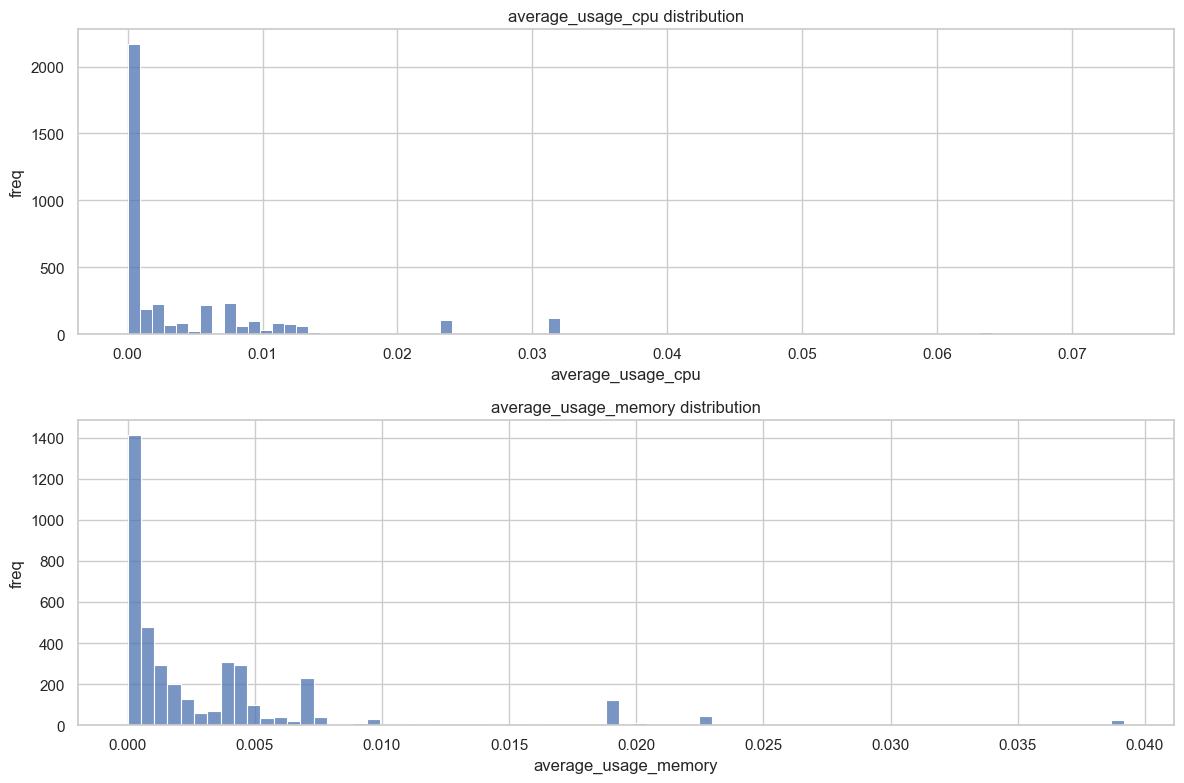

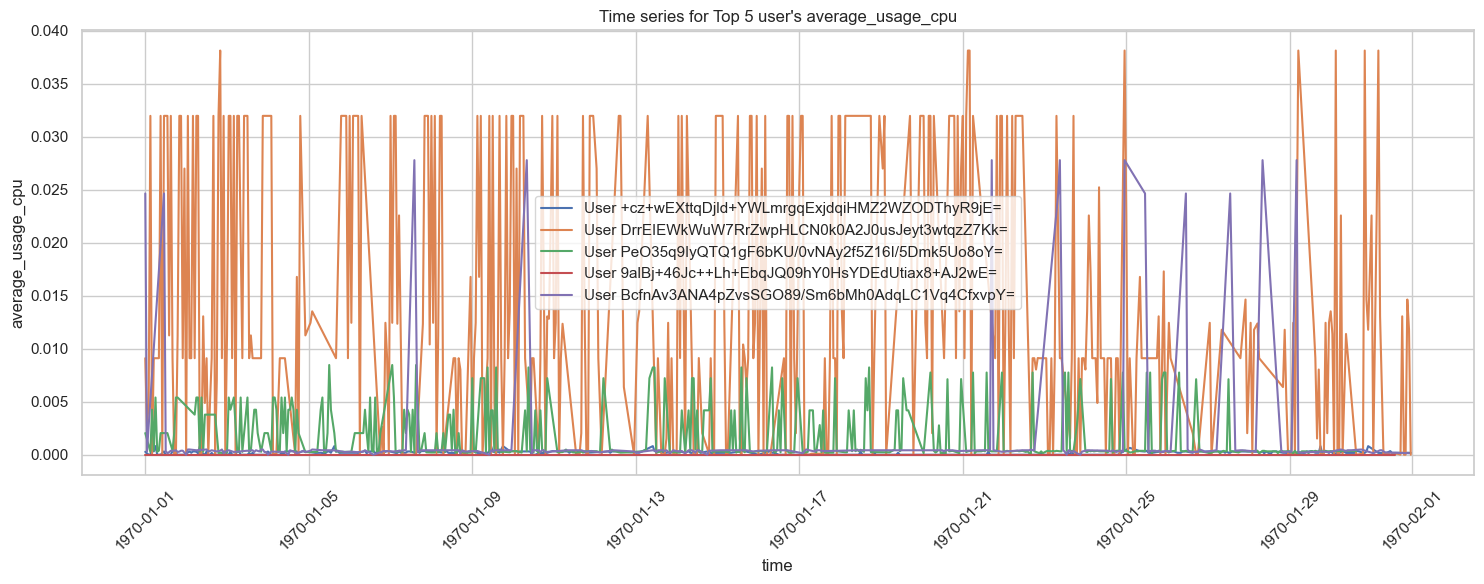

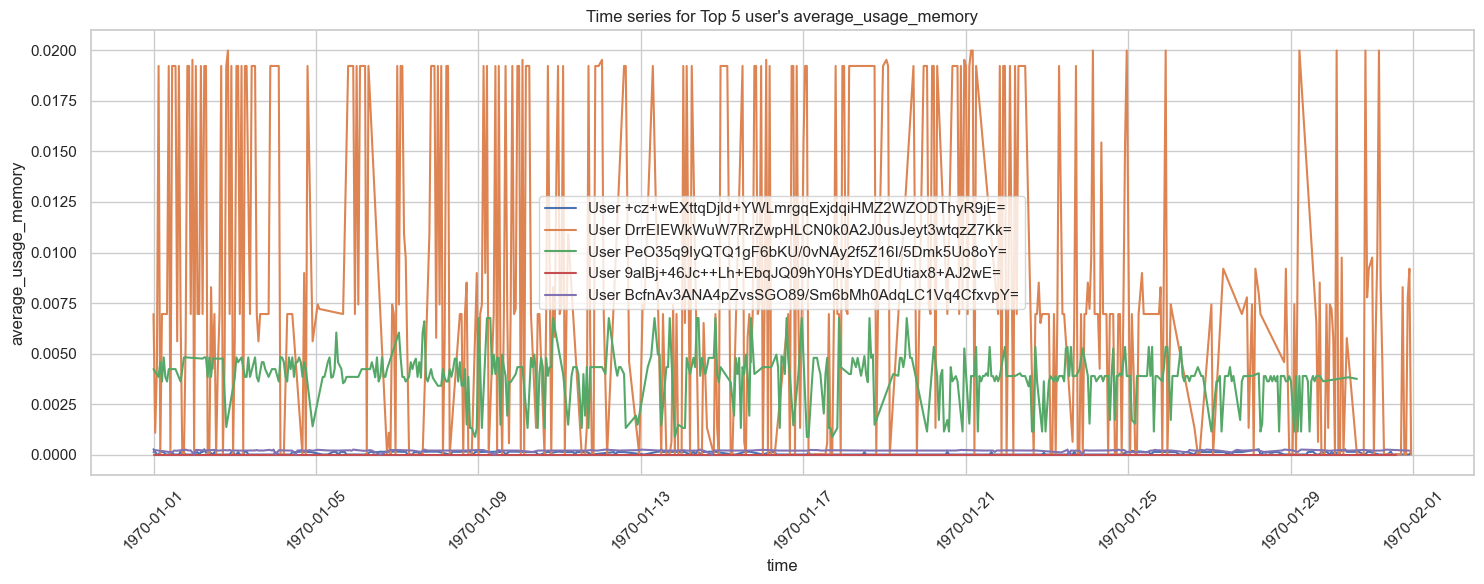

In [80]:
# 可视化用户资源使用分布
try:
    if 'user_hourly' in locals():
        # 选择一些关键特征进行可视化
        #key_features = [col for col in user_hourly.columns if '_mean' in col][:4]  # 选择前4个均值特征
        key_features = [col for col in ['average_usage_cpu', 'average_usage_memory']] 
        if key_features:
            fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))
            if len(key_features) == 1:
                axes = [axes]
                
            for i, feature in enumerate(key_features):
                sns.histplot(user_hourly[feature], ax=axes[i])
                axes[i].set_title(f'{feature} distribution')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('freq')
            
            plt.tight_layout()
            plt.show()
            
            # 选择前5个用户，查看其资源使用时间序列
            top_users = user_hourly['user'].value_counts().nlargest(5).index
            
            for feature in key_features:
                plt.figure(figsize=(15, 6))
                for user in top_users:
                    user_data = user_hourly[user_hourly['user'] == user]
                    if not user_data.empty:
                        plt.plot(user_data['hour'], user_data[feature], label=f'User {user}')
                
                #plt.title(f'Top 5 用户的 {feature} 时间序列')
                plt.title(f"Time series for Top 5 user's {feature}")
                plt.xlabel('time')
                plt.ylabel(feature)
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    else:
        print("没有找到用户时间序列数据进行可视化")
except Exception as e:
    print(f"数据可视化时出错: {e}")

## 4. 总结与下一步

在这个笔记本中，我们完成了以下工作：
1. 加载并探索了cluster_1的数据
2. 处理了时间特征
3. 提取了用户视角的关键特征
4. 处理了资源使用信息
5. 处理了缺失值
6. 构建了用户级别的时间序列特征
7. 标准化了数值特征
8. 可视化了关键资源使用模式

下一步：
1. 基于处理后的数据构建时间序列预测模型
2. 评估不同模型的预测性能
3. 进行特征重要性分析
4. 将预测结果与实际资源使用进行比较分析